In [1]:
import warnings
warnings.filterwarnings('ignore')

from lightgbm import LGBMClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
train = pd.read_csv('./data/H1_cleaned.csv')
test = pd.read_csv('./data/H2_cleaned.csv')

In [3]:
train['is_canceled'].value_counts()

0    24142
1     9035
Name: is_canceled, dtype: int64

In [4]:
test['is_canceled'].value_counts()

0    43226
1    30213
Name: is_canceled, dtype: int64

### Feature Engineering

#### Label Encoder

In [5]:
df_le = train.copy()
le = LabelEncoder()

categoricals = [
    'arrival_date_month',
    'meal',
    'country',
    'market_segment',
    'distribution_channel',
    'reserved_room_type',
    'assigned_room_type',
    'deposit_type',
    'agent',
    'company',
    'customer_type',
    'reservation_status',
]

for col in categoricals:
    df_le[col] = le.fit_transform(df_le[col])

#### Correlation

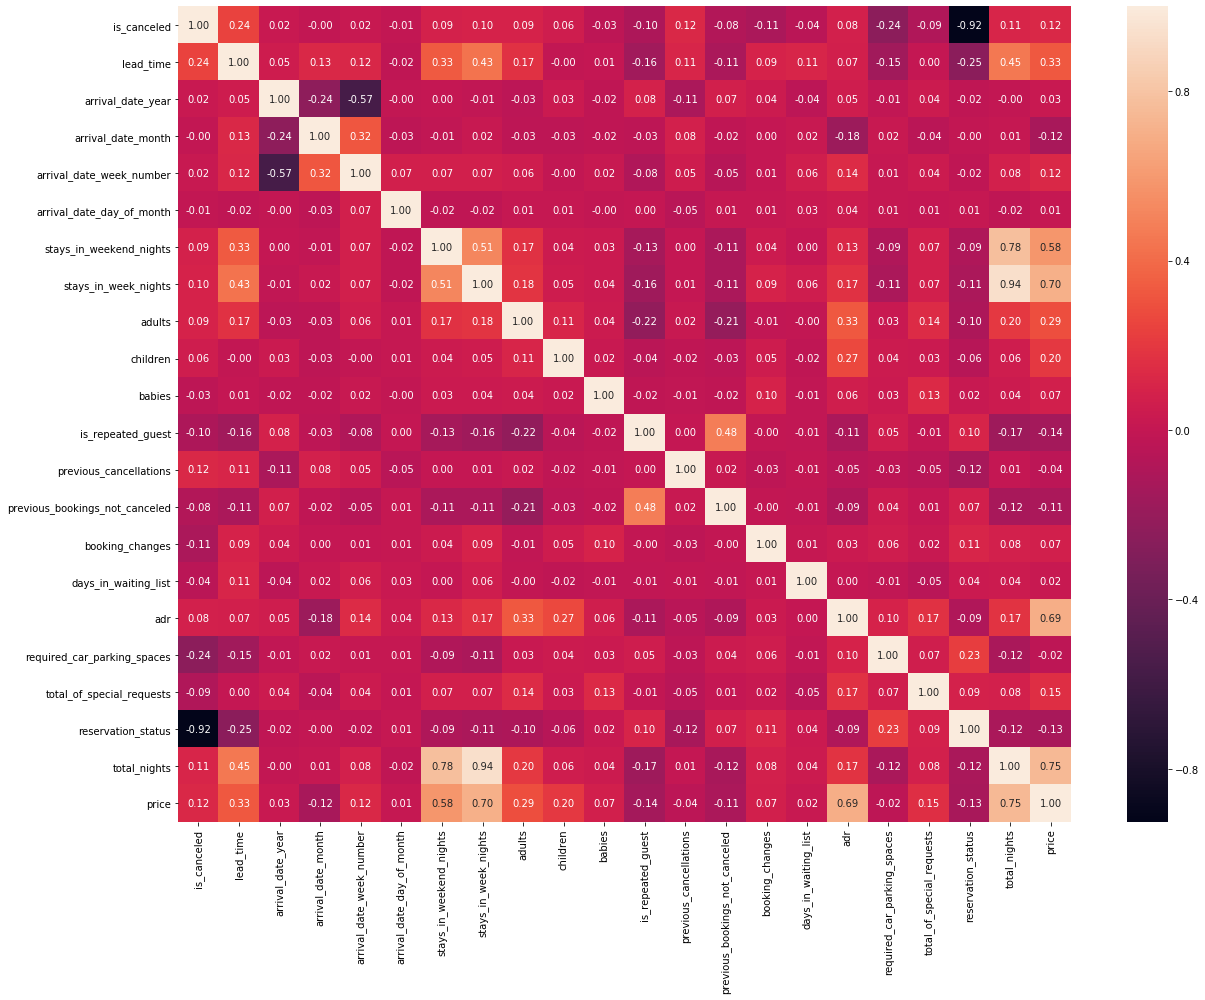

In [6]:
# numerical 
drop_cols = [
    'meal',
    'country',
    'market_segment',
    'distribution_channel',
    'reserved_room_type',
    'assigned_room_type',
    'deposit_type',
    'customer_type',
    'agent',
    'company',
]

plt.figure(figsize=(20, 15))
sns.heatmap(df_le.drop(drop_cols, axis=1).corr(), annot=True, fmt='.2f');

In [7]:
columns = [
    'reservation_status_date',
    'total_nights',
    'reservation_status',
]
train = train.drop(columns, axis=1)
test = test.drop(columns, axis=1)
df_le = df_le.drop(columns, axis=1)

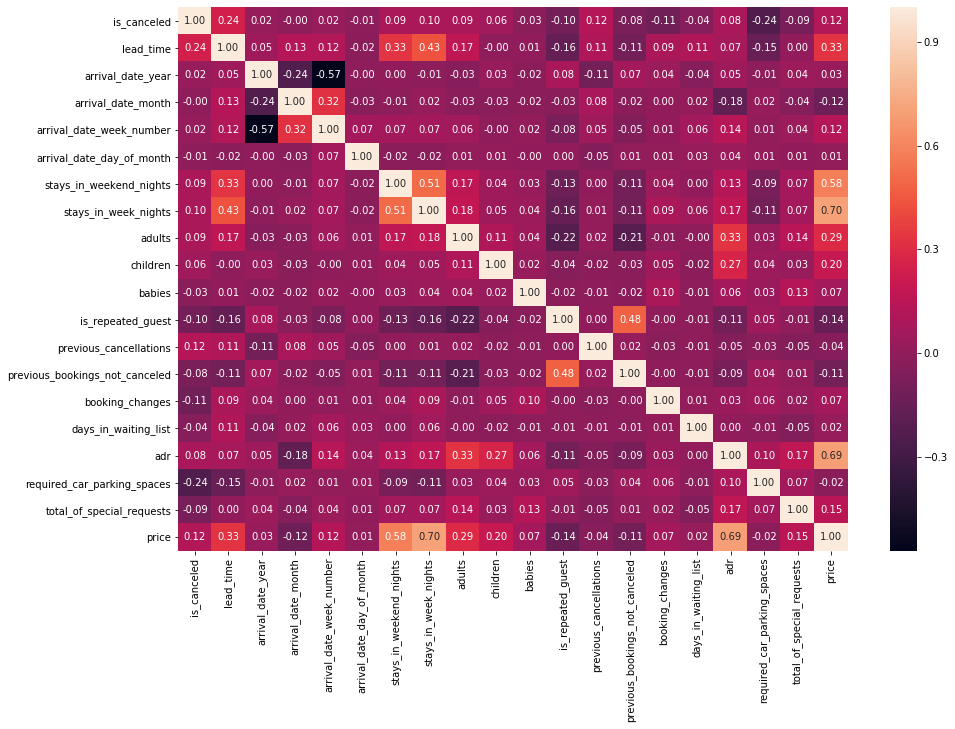

In [8]:
plt.figure(figsize=(15, 10))
sns.heatmap(df_le.drop(drop_cols, axis=1).corr(), annot=True, fmt='.2f');

#### Dummy Variables vs Label Encoder

In [9]:
new_categoricals = [col for col in categoricals if col in train.columns]
df_hot = pd.get_dummies(data=train, columns=new_categoricals)
test_hot = pd.get_dummies(data=test, columns=new_categoricals)

In [10]:
X_hot = df_hot.drop('is_canceled', axis=1)
X_le = df_le.drop('is_canceled', axis=1)
y = train['is_canceled']

##### Feature Elimination

In [11]:
def select(X):
    selects = []
    
    selector = SelectKBest(chi2, k='all').fit(X, y)
    scores = selector.scores_
        
    q3 = np.quantile(scores, 0.75)
    q1 = np.quantile(scores, 0.25)
    iqr = q3 - q1
    threshold = q3 + 1.5 * iqr

    for col, val in zip(X.columns, scores):
        cond1 = val > threshold
        cond2 = col in test_hot.columns or col in test.columns
        
        if cond1 and cond2:
            if col not in test_hot.columns:
                test_hot.loc[:, col] = 0
            selects.append(col)
        
    return selects

In [12]:
selects_hot = select(X_hot)
selects_le = select(X_le)

In [13]:
def compare():
    for is_le in [True, False]:
        method = 'label encoder'
        
        if is_le:
            selected = df_le[selects_le + ['is_canceled']]
        else:
            selected = df_hot[selects_hot + ['is_canceled']]
            method = 'dummy variables'
        
        # separate majority and minority classes
        df_majority = selected[selected['is_canceled'] == 0]
        df_minority = selected[selected['is_canceled'] == 1]

        # downsample majority class
        df_downsampled = resample(df_majority, replace=False, n_samples=len(df_minority), random_state=123) 

        # combine minority class with downsampled majority class
        df_new = pd.concat([df_downsampled, df_minority])
    
        X = df_new.drop('is_canceled', axis=1)
        y = df_new['is_canceled']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

        log = LogisticRegression().fit(X_train, y_train)
        y_pred = log.predict(X_test)

        print(f'Accuracy for {method}: {accuracy_score(y_test, y_pred)}')
        print(f'Classification report for {method}:\n{classification_report(y_test, y_pred)}')

In [14]:
compare()

Accuracy for label encoder: 0.698671831765357
Classification report for label encoder:
              precision    recall  f1-score   support

           0       0.69      0.71      0.70      1806
           1       0.70      0.69      0.70      1808

    accuracy                           0.70      3614
   macro avg       0.70      0.70      0.70      3614
weighted avg       0.70      0.70      0.70      3614

Accuracy for dummy variables: 0.8323187603763144
Classification report for dummy variables:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1806
           1       0.83      0.83      0.83      1808

    accuracy                           0.83      3614
   macro avg       0.83      0.83      0.83      3614
weighted avg       0.83      0.83      0.83      3614



In [15]:
last = test_hot[selects_hot + ['is_canceled']]

X_last = last.drop('is_canceled', axis=1)
y_last = last['is_canceled']

In [16]:
selected = df_hot[selects_hot + ['is_canceled']]

In [17]:
# separate majority and minority classes
# df_maj = selected[selected['is_canceled'] == 0]
# df_min = selected[selected['is_canceled'] == 1]

# upsample minority class
# df_min_upsampled = resample(df_min, replace=True, n_samples=len(df_maj), random_state=123) 

# combine majority class with upsampled minority class
# df_new = pd.concat([df_maj, df_min_upsampled])

# display new class counts
# df_new['is_canceled'].value_counts()

In [18]:
# separate majority and minority classes
df_majority = selected[selected['is_canceled'] == 0]
df_minority = selected[selected['is_canceled'] == 1]

# downsample majority class
df_downsampled = resample(df_majority, replace=False, n_samples=len(df_minority), random_state=123) 

# combine minority class with downsampled majority class
df_new = pd.concat([df_downsampled, df_minority])

# display new class counts
df_new['is_canceled'].value_counts()

1    9035
0    9035
Name: is_canceled, dtype: int64

In [19]:
X = df_new.drop('is_canceled', axis=1)
y = df_new['is_canceled']

In [20]:
X = df_new.drop('is_canceled', axis=1)
y = df_new['is_canceled']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

### Modelling

#### Logistic Regression

In [22]:
log = LogisticRegression().fit(X_train, y_train)

In [23]:
y_pred = log.predict(X_test)

In [24]:
accuracy_score(y_test, y_pred)

0.8323187603763144

In [25]:
confusion_matrix(y_test, y_pred)

array([[1499,  307],
       [ 299, 1509]])

In [26]:
cross_val_score(log, X_test, y_test, cv=10).mean()

0.824555961970449

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1806
           1       0.83      0.83      0.83      1808

    accuracy                           0.83      3614
   macro avg       0.83      0.83      0.83      3614
weighted avg       0.83      0.83      0.83      3614



#### Naive Bayes

In [28]:
nb = GaussianNB().fit(X_train, y_train)

In [29]:
y_pred = nb.predict(X_test)

In [30]:
accuracy_score(y_test, y_pred)

0.7484781405644715

In [31]:
confusion_matrix(y_test, y_pred)

array([[1335,  471],
       [ 438, 1370]])

In [32]:
cross_val_score(nb, X_test, y_test, cv=10).mean()

0.7415273462807935

In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.74      0.75      1806
           1       0.74      0.76      0.75      1808

    accuracy                           0.75      3614
   macro avg       0.75      0.75      0.75      3614
weighted avg       0.75      0.75      0.75      3614



#### KNN

In [34]:
knn = KNeighborsClassifier().fit(X_train, y_train)

In [35]:
knn = KNeighborsClassifier().fit(X_train, y_train)

In [36]:
y_pred = knn.predict(X_test)

In [37]:
accuracy_score(y_test, y_pred)

0.6892639734366353

In [38]:
confusion_matrix(y_test, y_pred)

array([[1229,  577],
       [ 546, 1262]])

In [39]:
cross_val_score(knn, X_test, y_test, cv=10).mean()

0.6248256412087698

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.68      0.69      1806
           1       0.69      0.70      0.69      1808

    accuracy                           0.69      3614
   macro avg       0.69      0.69      0.69      3614
weighted avg       0.69      0.69      0.69      3614



- Model Tuning

In [41]:
knn_params = {'n_neighbors': range(1, 11)}

In [42]:
params = {
    'estimator': knn,
    'param_grid': knn_params,
    'cv': 5,
    'refit': False,
    'n_jobs': -1,
    'verbose': 2,
    'scoring': 'recall',
}
knn_cv = GridSearchCV(**params)

In [43]:
_ = knn_cv.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.8s finished


In [44]:
knn_cv.best_params_

{'n_neighbors': 1}

In [45]:
knn = KNeighborsClassifier(**knn_cv.best_params_).fit(X_train, y_train)

In [46]:
y_pred = knn.predict(X_test)

In [47]:
accuracy_score(y_test, y_pred)

0.7011621472053127

In [48]:
cross_val_score(knn, X_test, y_test, cv=10).mean()

0.6204018916147594

In [49]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.68      0.69      1806
           1       0.69      0.72      0.71      1808

    accuracy                           0.70      3614
   macro avg       0.70      0.70      0.70      3614
weighted avg       0.70      0.70      0.70      3614



#### Decision Tree

In [50]:
cart = DecisionTreeClassifier(max_depth=2).fit(X_train, y_train)

In [51]:
y_pred = cart.predict(X_test)

In [52]:
accuracy_score(y_test, y_pred)

0.7324294410625346

In [53]:
confusion_matrix(y_test, y_pred)

array([[1537,  269],
       [ 698, 1110]])

In [54]:
cross_val_score(cart, X_test, y_test, cv=10).mean()

0.7548615000960772

In [55]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.85      0.76      1806
           1       0.80      0.61      0.70      1808

    accuracy                           0.73      3614
   macro avg       0.75      0.73      0.73      3614
weighted avg       0.75      0.73      0.73      3614



- Model Tuning

In [56]:
cart_params = {
    'max_depth': range(5, 25, 5),
    'min_samples_split' : range(2, 50), 
}

In [57]:
params = {
    'estimator': cart,
    'param_grid': cart_params,
    'cv': 5,
    'refit': False,
    'n_jobs': -1,
    'verbose': 2,
    'scoring': 'recall',
}
cart_cv = GridSearchCV(**params)

In [58]:
_ = cart_cv.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:   52.9s finished


In [59]:
cart_cv.best_params_

{'max_depth': 5, 'min_samples_split': 2}

In [60]:
cart = DecisionTreeClassifier(**cart_cv.best_params_).fit(X_train, y_train)

In [61]:
y_pred = cart.predict(X_test)

In [62]:
accuracy_score(y_test, y_pred)

0.8350857775318207

In [63]:
cross_val_score(cart, X_test, y_test, cv=10).mean()

0.8381332887807383

In [64]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.78      0.83      1806
           1       0.80      0.89      0.84      1808

    accuracy                           0.84      3614
   macro avg       0.84      0.84      0.83      3614
weighted avg       0.84      0.84      0.83      3614



#### Random Forests

In [65]:
rf = RandomForestClassifier().fit(X_train, y_train)

In [66]:
y_pred = rf.predict(X_test)

In [67]:
accuracy_score(y_test, y_pred)

0.8696734919756502

In [68]:
confusion_matrix(y_test, y_pred)

array([[1591,  215],
       [ 256, 1552]])

In [69]:
cross_val_score(rf, X_test, y_test, cv=10).mean()

0.8408857591541128

In [70]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1806
           1       0.88      0.86      0.87      1808

    accuracy                           0.87      3614
   macro avg       0.87      0.87      0.87      3614
weighted avg       0.87      0.87      0.87      3614



- Model Tuning

In [71]:
rf_params = {
    'max_depth': [5, 10, 15, 20],
    'max_features': [2, 3, 5],
    'n_estimators': [100, 500, 1000],
    'min_samples_split': [5, 10, 15],
}

In [72]:
params = {
    'estimator': rf,
    'param_grid': rf_params,
    'cv': 5,
    'refit': False,
    'n_jobs': -1,
    'verbose': 2,
    'scoring': 'recall',
}
rf_cv = GridSearchCV(**params)

In [73]:
_ = rf_cv.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 11.8min finished


In [74]:
rf_cv.best_params_

{'max_depth': 20,
 'max_features': 5,
 'min_samples_split': 5,
 'n_estimators': 500}

In [75]:
rf = RandomForestClassifier(**rf_cv.best_params_).fit(X_train, y_train)

In [76]:
y_pred = rf.predict(X_test)

In [77]:
accuracy_score(y_test, y_pred)

0.8754842280022136

In [78]:
cross_val_score(rf, X_test, y_test, cv=10).mean()

0.8563844888950107

In [79]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.86      0.87      1806
           1       0.87      0.89      0.88      1808

    accuracy                           0.88      3614
   macro avg       0.88      0.88      0.88      3614
weighted avg       0.88      0.88      0.88      3614



#### Gradient Boosting Machines

In [80]:
gbm = GradientBoostingClassifier().fit(X_train, y_train)

In [81]:
y_pred = gbm.predict(X_test)

In [82]:
accuracy_score(y_test, y_pred)

0.863032650802435

In [83]:
confusion_matrix(y_test, y_pred)

array([[1500,  306],
       [ 189, 1619]])

In [84]:
cross_val_score(gbm, X_test, y_test, cv=10).mean()

0.8550155551474401

In [85]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.83      0.86      1806
           1       0.84      0.90      0.87      1808

    accuracy                           0.86      3614
   macro avg       0.86      0.86      0.86      3614
weighted avg       0.86      0.86      0.86      3614



- Model Tuning

In [86]:
gbm_params = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
}

In [87]:
params = {
    'estimator': gbm,
    'param_grid': gbm_params,
    'cv': 5,
    'refit': False,
    'n_jobs': -1,
    'verbose': 2,
    'scoring': 'recall',
}
gbm_cv = GridSearchCV(**params)

In [88]:
_ = gbm_cv.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 52.1min finished


In [89]:
gbm_cv.best_params_

{'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 500}

In [90]:
gbm = GradientBoostingClassifier(**gbm_cv.best_params_).fit(X_train, y_train)

In [91]:
y_pred = gbm.predict(X_test)

In [92]:
accuracy_score(y_test, y_pred)

0.8876591034864416

In [93]:
cross_val_score(gbm, X_test, y_test, cv=10).mean()

0.8522523717454924

In [94]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.87      0.89      1806
           1       0.87      0.91      0.89      1808

    accuracy                           0.89      3614
   macro avg       0.89      0.89      0.89      3614
weighted avg       0.89      0.89      0.89      3614



#### XGBoost

In [95]:
xgb = XGBClassifier().fit(X_train, y_train)

In [96]:
y_pred = xgb.predict(X_test)

In [97]:
accuracy_score(y_test, y_pred)

0.8635860542335363

In [98]:
confusion_matrix(y_test, y_pred)

array([[1494,  312],
       [ 181, 1627]])

In [99]:
cross_val_score(xgb, X_test, y_test, cv=10).mean()

0.859997130438775

In [100]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.83      0.86      1806
           1       0.84      0.90      0.87      1808

    accuracy                           0.86      3614
   macro avg       0.87      0.86      0.86      3614
weighted avg       0.87      0.86      0.86      3614



- Model Tuning

In [101]:
xgb_params = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
}

In [102]:
params = {
    'estimator': xgb,
    'param_grid': xgb_params,
    'cv': 5,
    'refit': False,
    'n_jobs': -1,
    'verbose': 2,
    'scoring': 'recall',
}
xgb_cv = GridSearchCV(**params)

In [103]:
_ = xgb_cv.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 41.4min finished


In [104]:
xgb_cv.best_params_

{'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}

In [105]:
xgb = XGBClassifier(**xgb_cv.best_params_).fit(X_train, y_train)

In [106]:
y_pred = xgb.predict(X_test)

In [107]:
accuracy_score(y_test, y_pred)

0.8790813503043718

In [108]:
cross_val_score(xgb, X_test, y_test, cv=10).mean()

0.8533488842295716

In [109]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88      1806
           1       0.86      0.90      0.88      1808

    accuracy                           0.88      3614
   macro avg       0.88      0.88      0.88      3614
weighted avg       0.88      0.88      0.88      3614



#### Light GBM

In [110]:
lgbm = LGBMClassifier().fit(X_train, y_train)

In [111]:
y_pred = lgbm.predict(X_test)

In [112]:
accuracy_score(y_test, y_pred)

0.8796347537354732

In [113]:
confusion_matrix(y_test, y_pred)

array([[1555,  251],
       [ 184, 1624]])

In [114]:
cross_val_score(lgbm, X_test, y_test, cv=10).mean()

0.8569415791344213

In [115]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.86      0.88      1806
           1       0.87      0.90      0.88      1808

    accuracy                           0.88      3614
   macro avg       0.88      0.88      0.88      3614
weighted avg       0.88      0.88      0.88      3614



- Model Tuning

In [116]:
lgbm_params = {
    'n_estimators': [100, 500, 1000, 2000],
    'subsample': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.1, 0.01, 0.02, 0.05],
    'min_child_samples': [5, 10, 20],
}

In [117]:
params = {
    'estimator': lgbm,
    'param_grid': lgbm_params,
    'cv': 5,
    'refit': False,
    'n_jobs': -1,
    'verbose': 2,
    'scoring': 'recall',
}
lgbm_cv = GridSearchCV(**params)

In [118]:
_ = lgbm_cv.fit(X_train, y_train)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 24.0min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 32.1min
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed: 36.9min finished


In [119]:
lgbm_cv.best_params_

{'learning_rate': 0.02,
 'max_depth': 5,
 'min_child_samples': 20,
 'n_estimators': 100,
 'subsample': 0.6}

In [120]:
lgbm = LGBMClassifier(**lgbm_cv.best_params_).fit(X_train, y_train)

In [121]:
y_pred = lgbm.predict(X_test)

In [122]:
accuracy_score(y_test, y_pred)

0.853901494189264

In [123]:
cross_val_score(lgbm, X_test, y_test, cv=10).mean()

0.852802536777147

In [124]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.80      0.84      1806
           1       0.82      0.91      0.86      1808

    accuracy                           0.85      3614
   macro avg       0.86      0.85      0.85      3614
weighted avg       0.86      0.85      0.85      3614



### Final

In [125]:
for model in [rf, gbm, xgb, lgbm]:
    y_pred_last = model.predict(X_last)
    print(model.__class__.__name__)
    print('Accuracy Score:\n')
    print(accuracy_score(y_last, y_pred_last))
    print('\nClassification Report:\n')
    print(classification_report(y_last, y_pred_last))

RandomForestClassifier
Accuracy Score:

0.7583572761067008

Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.89      0.81     43226
           1       0.79      0.56      0.66     30213

    accuracy                           0.76     73439
   macro avg       0.77      0.73      0.74     73439
weighted avg       0.76      0.76      0.75     73439

GradientBoostingClassifier
Accuracy Score:

0.7499285120984763

Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.87      0.80     43226
           1       0.76      0.58      0.65     30213

    accuracy                           0.75     73439
   macro avg       0.75      0.72      0.73     73439
weighted avg       0.75      0.75      0.74     73439

XGBClassifier
Accuracy Score:

0.7517531556802244

Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.88      0.81 